In [1]:
import numpy as np
import cft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from scipy.spatial import ConvexHull

from adhesion import get_convex_hull, plot_regular_triangulation, plot_power_diagram

In [2]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['lines.solid_capstyle'] = 'round'

def plot_image(box, data, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.imshow(data, extent=[-box.L/2, box.L/2, -box.L/2, box.L/2], interpolation='nearest', cmap='RdYlBu')
    plt.show()

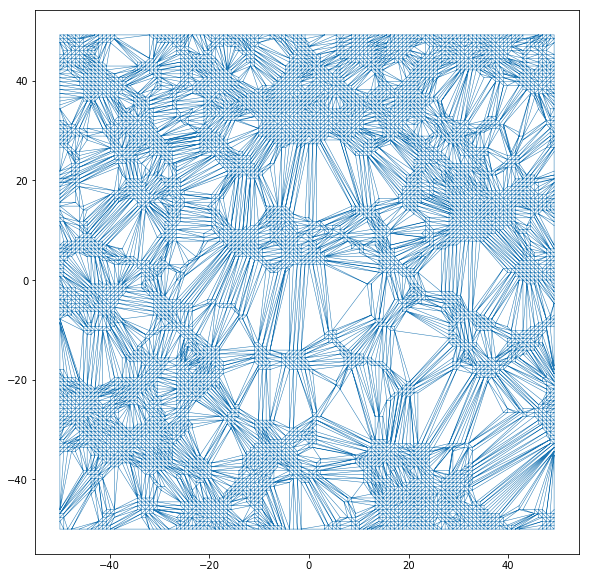

In [99]:
box = cft.Box(dim=2, N=128, L=100.)
P = cft.Power_law(n=-1) * cft.Scale(box, 1.0)
delta_0 = cft.garfield(B=box, P=P, seed=44)
delta_0 /= delta_0.std()
pot_0 = np.fft.ifftn(np.fft.fftn(delta_0) * cft.Potential()(box.K)).real

ch, selection, valid = get_convex_hull(box, pot_0, 2.0)

xlim = None
ylim = None

plot_regular_triangulation(ch, selection, xlim, ylim)
plt.show()

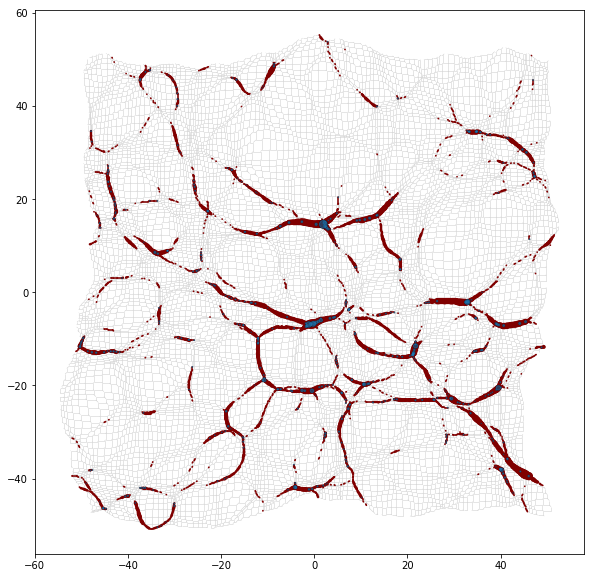

In [106]:
plot_power_diagram(box, ch, valid, xlim, ylim, point_scale=1)
plt.show()

In [101]:
def velocities(ch, t, selection=None):
    q = ch.points.copy()
    q[:,2] = (q[:,2] - (q[:,:2]**2).sum(axis=1)) / (-2 * t)
    verts = q[ch.simplices[selection]]
    normals = np.cross(verts[:,1,:] - verts[:,0,:], verts[:,2,:] - verts[:,0,:])
    return normals[:,:2]/normals[:,2:]

In [167]:
from adhesion import voronoi_points, delaunay_areas, edges, edge_length, edge_points, delaunay_class
from scipy.interpolate import griddata

def plot_velocities(box, ch, t, selection, xlim=None, ylim=None, point_scale=1, ax = None):
    X = voronoi_points(ch, selection)
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_aspect('equal')
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    
    sp = X[np.where(
            np.logical_and(
                np.logical_and(X[:,0] > -box.L/3, X[:,0] < box.L/3),
                np.logical_and(X[:,1] > -box.L/3, X[:,1] < box.L/3)))[0]]
    v = velocities(ch, t, selection)
    G = np.indices(box.shape) * box.res - box.L / 2
    v0 = griddata(X, v[:,0], (G[1].flatten(), G[0].flatten())).reshape(box.shape)
    v1 = griddata(X, v[:,1], (G[1].flatten(), G[0].flatten())).reshape(box.shape)
    lw = (v0**2 + v1**2) / 15 + 1
    ax.streamplot(np.arange(box.shape[0]) * box.res - box.L/2,
                  np.arange(box.shape[0]) * box.res - box.L/2,
                  v0, v1,
                  density=5, color='black', zorder=2, linewidth=0.8,
                  #start_points=sp
                 )
    
    m_edges = edges(box, ch, valid)
    m_edge_lengths = edge_length(ch, m_edges)
    m_edge_points = edge_points(ch, m_edges)

    X = voronoi_points(ch, valid)
    mass = delaunay_areas(box, ch, valid)
    big_points = np.where(delaunay_class(box, ch, valid, threshold=1.0) > 2)

    edge_sel = np.where(m_edge_lengths > np.sqrt(2)*box.res)[0]
    lc = collections.LineCollection(
        m_edge_points[edge_sel], linewidths=m_edge_lengths[edge_sel], color='maroon',
        zorder=5, alpha=0.5)
    # lc.set_capstyle('round')
    ax.add_collection(lc)
    # ax.quiver(X[:,0], X[:,1], v[:,0], v[:,1])
    ax.scatter(X[big_points,0], X[big_points,1], s=mass[big_points]**1.5 * point_scale * 1.25, zorder=22, c='black', alpha=0.35)
    ax.scatter(X[big_points,0], X[big_points,1], s=mass[big_points]**1.5 * point_scale, zorder=24, alpha=0.35)
    # plt.show()

# ch, selection, valid = get_convex_hull(box, pot_0, 1.5)
# plot_velocities(box, ch, 1.5, valid, xlim=[-30,30], ylim=[-30,30], point_scale=5)

In [168]:
box = cft.Box(dim=2, N=128, L=100.)
P = cft.Power_law(n=0) * cft.Scale(box, 1.5)
delta_0 = cft.garfield(B=box, P=P, seed=44)
delta_0 /= delta_0.std()
pot_0 = np.fft.ifftn(np.fft.fftn(delta_0) * cft.Potential()(box.K)).real

[]

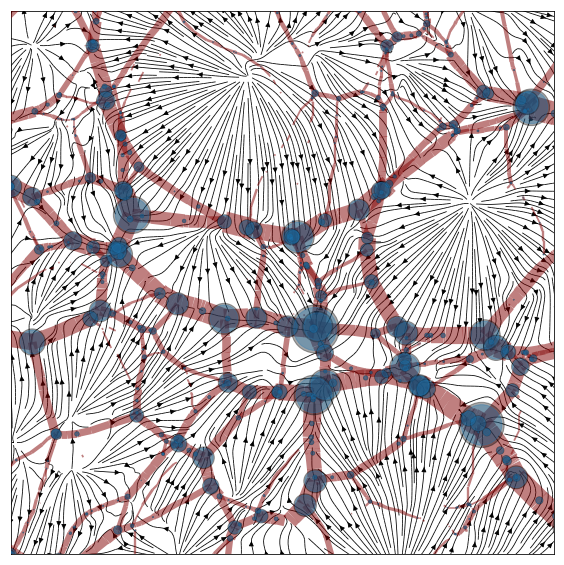

In [169]:
ch, selection, valid = get_convex_hull(box, pot_0, 5)
fig = plt.figure()
ax = fig.add_subplot(111)
plot_velocities(box, ch, 5, valid, xlim=[-45,45], ylim=[-45,45], point_scale=1, ax=ax)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

In [171]:
fig.savefig("streamlines.png", bbox_inches='tight')